In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import re
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

# Ground Truth

In [2]:
read = np.loadtxt('KITTI  sample dataset/dataset/poses/00.txt')
Rs = np.reshape(read,(3*len(read),4))[:,:-1]
translation = np.reshape(np.reshape(read,(3*len(read),4))[:,-1:],(len(read),3))
rotation = np.zeros([len(read),3,3])
rotation[0:len(read),0,:] = Rs[::3,:]
rotation[0:len(read),1,:] = Rs[1::3,:]
rotation[0:len(read),2,:] = Rs[2::3,:]

<IPython.core.display.Javascript object>


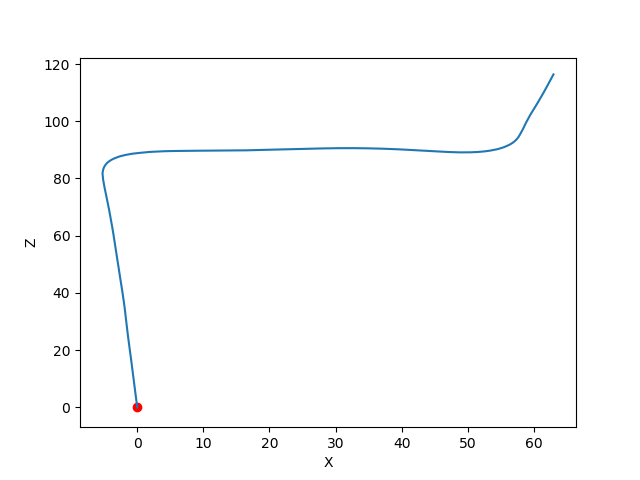

In [3]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(translation[:250,0], translation[:250,2])
ax.scatter(translation[0,0], translation[0,2], c='r')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

<IPython.core.display.Javascript object>


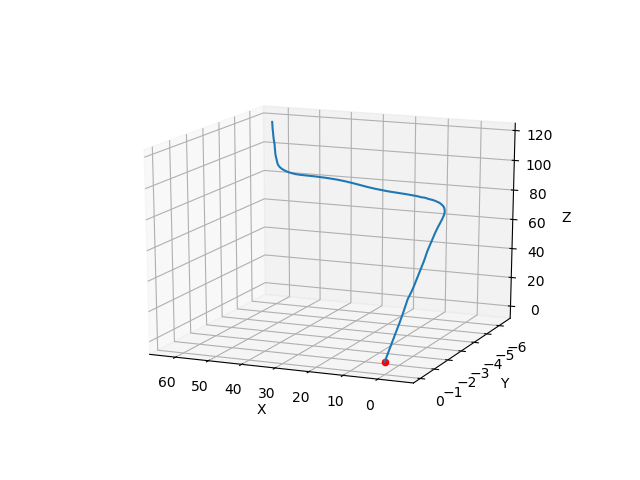

In [4]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(translation[:250,0], translation[:250,1], translation[:250,2])
ax.scatter(translation[0,0], translation[0,1], translation[0,2], c='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Evaluation

In [5]:
# Find Intrinsic Parameters
with open('KITTI  sample dataset/dataset/sequences/00/calib.txt', 'r') as f:
    P = re.split('\n| ', f.read())
P0 = np.array([float(x) for x in P[1:13]]).reshape((3,4))
fl = P0[0, 0]
pp = (P0[0, 2], P0[1, 2])

In [6]:
def solve(index):
    IMG_DIR = 'image_0/'
    num1 = str(index/1000)[2:]
    num2 = str((index+1)/1000)[2:]
    IMG_NAME_1 = '000'+num1+'0'*(3-len(num1))+'.png'
    IMG_NAME_2 = '000'+num2+'0'*(3-len(num2))+'.png'

    img_1 = cv2.imread(IMG_DIR + IMG_NAME_1)
    img_2 = cv2.imread(IMG_DIR + IMG_NAME_2)

    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img_1,None)
    kp2, des2 = sift.detectAndCompute(img_2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
    pts1_E = np.asarray(pts1)
    pts2_E = np.asarray(pts2)
    E, mask = cv2.findEssentialMat(pts1_E, pts2_E, focal=fl, pp=pp)
    _, R, t, _ = cv2.recoverPose(E, pts1_E, pts2_E, focal=fl, pp=pp, mask=mask)
    return E, R, t.T

In [7]:
index = 250
E = np.load('0-249/E_0-249.npy')
r = np.load('0-249/r_0-249.npy')
t = np.load('0-249/t_0-249.npy')

# --------------------------------------------------------------------------------
# E = np.zeros((index, 3, 3))
# r = np.zeros((index, 3, 3))
# t = np.zeros((index, 3))
# for i in range(index):
#     E[i], r[i], t[i] = solve(i)
#     if i % 10 == 0:
#         logging.info('Image '+str(i)+' read.')

# np.save('0-249/E_0-249', E)
# np.save('0-249/r_0-249', r)
# np.save('0-249/t_0-249', t)

In [8]:
# Check r (diagonal positive) and t (third negtive)
for i in r:
    if i[0,0] <= 0:
        print(i)
for i in t:
    if i[2] >= 0:
        print(i)

In [9]:
T = np.zeros(3)
R = np.eye(3)
T_list = np.zeros((index, 3))
R_list = np.zeros((index, 3, 3))
for i in range(index):
    T += R @ t[i]
    R = R @ r[i]
    T_list[i] = T
    R_list[i] = R

<IPython.core.display.Javascript object>


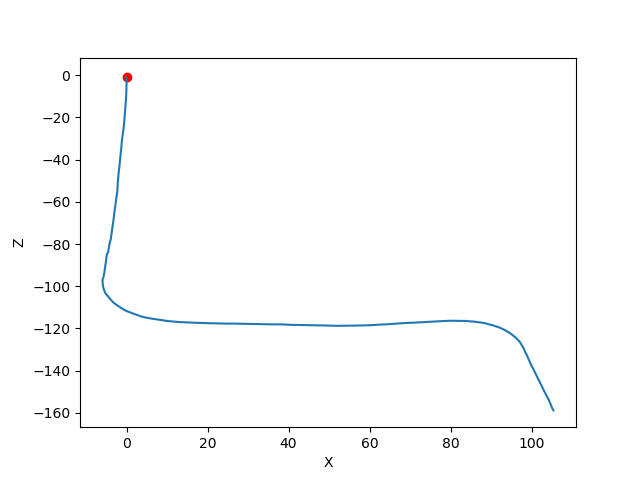

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(T_list[:,0], T_list[:,2])
ax.scatter(T_list[0,0], T_list[0,2], c='r')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

<IPython.core.display.Javascript object>


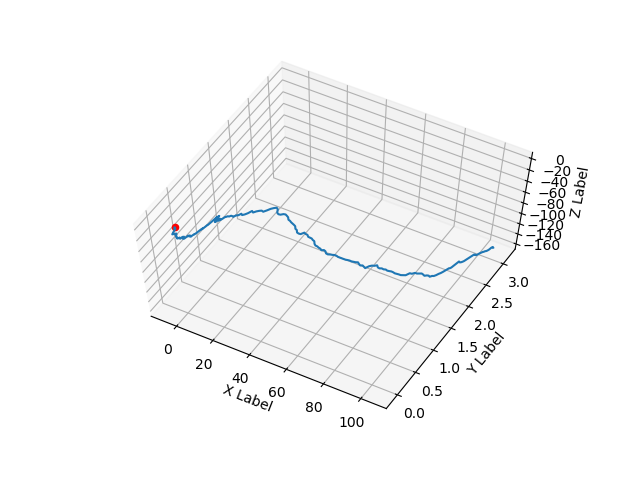

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(T_list[:,0], T_list[:,1], T_list[:,2])
ax.scatter(T_list[0,0], T_list[0,1], T_list[0,2], c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()